In [3]:
import json
import pandas as pd
import numpy as np
from model.text_normalizer import normalize_corpus, stopword_list
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import joblib

[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocessing

In [4]:
products = pd.read_json('https://raw.githubusercontent.com/anyoneai/e-commerce-open-data-set/master/products.json')

In [147]:
def create_dataset(data):
    '''
    Create dataset from raw data.
    
    Receives data in the form of a pandas DataFrame and builds a new DataFrame with
    the features and target needed to feed a prediction model.
    
    Parameters
    ----------
    data: pd.DataFrame
    
    Returns
    -------
    pd.DataFrame  
    '''
    df = pd.DataFrame()
    categories = []
    for path in products['category']:
        prod_cat = []
        for cat in path:
            prod_cat.append(cat['name'])
        categories.append(prod_cat)
    df['name'], df['description'] = data['name'], data['description']
    df['categories'] = categories
    cat = pd.DataFrame(df['categories'].to_list())
    unique_cat = []
    for category in cat:
        unique_cat.append(cat[category].unique())
    unique_cat = list(dict.fromkeys(np.concatenate(unique_cat)))
    unique_cat = [x for x in unique_cat if x is not None]
    cat = pd.concat([cat,pd.DataFrame(columns = list(unique_cat))])
    cat.fillna(0, inplace = True)
    for i in range(7):
        row = 0
        for category in cat[i]:
            if category!= 0:
                cat.loc[row,category] = 1
            row = row + 1
    df2 = pd.concat([df['name'],df['description'],cat.iloc[:,7:]],axis=1)
    return df2

In [163]:
df = create_dataset(products)

In [164]:
bar_plot = pd.DataFrame()
bar_plot['category'] = df.columns[2:]
bar_plot['count'] = df.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head()

,category,count
0,Appliances,9317
1,Cell Phones,6905
2,Cell Phone Accessories,6176
3,Computers & Tablets,6088
4,Video Games,5837


In [165]:
threshold = 100 

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>threshold]
categories = main_categories['category'].values
categories = np.append(categories,'Others')
not_category = []
df['Others'] = 0

for i in df.columns[2:]:
    if i not in categories:
        df['Others'][df[i] == 1] = 1
        not_category.append(i)

df.drop(not_category, axis=1, inplace=True)

/tmp/ipykernel_19/1189894228.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Others'] = 0
/tmp/ipykernel_19/1189894228.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Others'][df[i] == 1] = 1


In [166]:
most_common_cat = pd.DataFrame()
most_common_cat['category'] = df.columns[2:]
most_common_cat['count'] = df.iloc[:,2:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
most_common_cat.head()   

,category,count,class_weight
0,Others,22030,0.012211
1,Appliances,9317,0.028872
2,Cell Phones,6905,0.038957
3,Cell Phone Accessories,6176,0.043556
4,Computers & Tablets,6088,0.044185


In [167]:
def normalization(text):
    normalized = normalize_corpus(
        text,
        html_stripping=True,
        contraction_expansion=True,
        accented_char_removal=True,
        text_lower_case=True,
        text_stemming=True,
        text_lemmatization=False,
        special_char_removal=True,
        remove_digits=False,
        stopword_removal=True,
        stopwords=stopword_list
    )       
    return normalized

In [168]:
df['name'] = normalization(df['name'].apply(str))
df['description'] = normalization(df['description'].apply(str))

In [169]:
df['full_text'] = df['name'] + df['description']

# Modeling

In [170]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Flatten, LSTM, Dense, Embedding, Dropout
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import AUC

In [171]:
tokenizer = Tokenizer(num_words=5000, lower=True) 
tokenizer.fit_on_texts(df['full_text'])
sequences = tokenizer.texts_to_sequences(df['full_text'])
X = pad_sequences(sequences, maxlen=500)
y = df[df.columns[2:-1]]

In [172]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42)

In [186]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 500
class_weight = dict(zip(range(0,len(most_common_cat) + 1), most_common_cat.class_weight))

In [174]:
glove = open('data/glove.6B.100d.txt', encoding="utf8") 

In [175]:
embeddings_dictionary = dict()

for line in glove:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove.close()

embedding_matrix = np.zeros((max_words, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector    

In [178]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(max_words, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
dropout_embedding_layer = Dropout(0.2)(embedding_layer)
LSTM_Layer_1 = LSTM(300)(dropout_embedding_layer)
dropout_LSTM_Layer_1 =  Dropout(0.2)(LSTM_Layer_1)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(dropout_LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model/experiments/model-LSTM.h5', save_best_only=True)
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 100)          5149500   
                                                                 
 dropout_6 (Dropout)         (None, 500, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 300)               481200    
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 269)               80969     
                                                                 
Total params: 5,711,669
Trainable params: 562,169
Non-train

In [187]:
history = model.fit(X_train, y_train.values,
                    class_weight=class_weight,
                    batch_size=32, 
                    epochs=30, 
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30


2022-12-20 07:44:45.401095: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


791/791 [==============================] - 234s 292ms/step - loss: 0.0039 - auc_1: 0.7778 - val_loss: 0.0543 - val_auc_1: 0.8037 - lr: 0.0010
Epoch 2/30
791/791 [==============================] - 230s 290ms/step - loss: 0.0029 - auc_1: 0.8372 - val_loss: 0.0467 - val_auc_1: 0.8692 - lr: 0.0010
Epoch 3/30
791/791 [==============================] - 228s 288ms/step - loss: 0.0026 - auc_1: 0.8701 - val_loss: 0.0429 - val_auc_1: 0.8958 - lr: 0.0010
Epoch 4/30
791/791 [==============================] - 230s 290ms/step - loss: 0.0024 - auc_1: 0.8960 - val_loss: 0.0403 - val_auc_1: 0.9103 - lr: 0.0010
Epoch 5/30
791/791 [==============================] - 228s 288ms/step - loss: 0.0022 - auc_1: 0.9178 - val_loss: 0.0361 - val_auc_1: 0.9365 - lr: 0.0010
Epoch 6/30
791/791 [==============================] - 230s 290ms/step - loss: 0.0020 - auc_1: 0.9322 - val_loss: 0.0335 - val_auc_1: 0.9410 - lr: 0.0010
Epoch 7/30
791/791 [==============================] - 228s 288ms/step - loss: 0.0018 - auc_1:

# Evaluation

In [189]:
import matplotlib.pyplot as plt

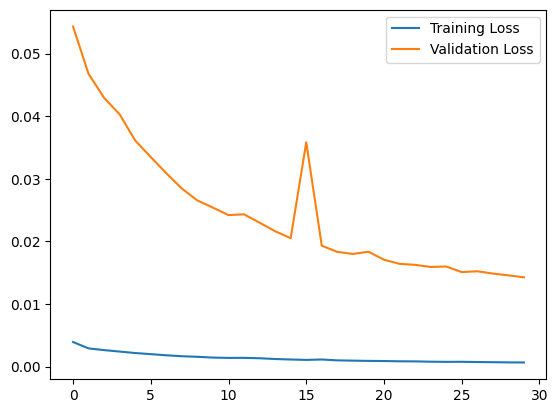

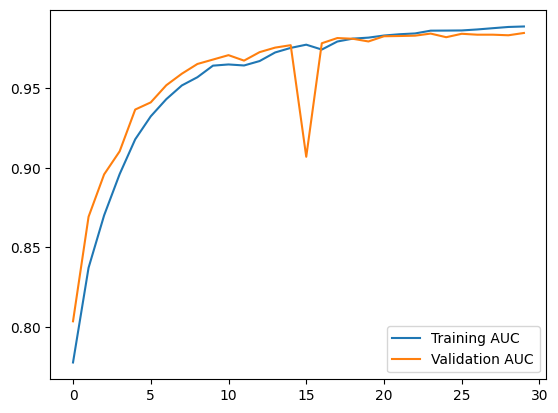

In [192]:
# Plotting accuracy 
plt.plot(history.history["auc_1"], label="Training AUC")
plt.plot(history.history["val_auc_1"], label="Validation AUC")
plt.legend()
plt.show()

In [204]:
classes = [col for col in df.columns]
classes = classes[2:-1]

In [199]:
import operator
def predict(name, description):
    # Data cleaning process
    name = normalization(name)
    description = normalization(description)
    full_text = name + description
    # Preprocessing
    sequences = tokenizer.texts_to_sequences([full_text])
    x = pad_sequences(sequences, maxlen=500)
    prediction = model.predict(x)
    pred_scores = [score for pred in prediction for score in pred]
    pred_dict = {}
    for cla,score in zip(classes,pred_scores):
        pred_dict[cla] = score
    return sorted(pred_dict.items(), key=operator.itemgetter(1),reverse=True)[:10] # Top 10

In [203]:
name = "Mac Book Pro Charger"
description = "Chargers include a built-in cooling system to prevent overheating even while operating at full power."
predict(name,description)

[('Monitors', 0.7294958),
 ('Computers & Tablets', 0.72931427),
 ('Others', 0.6104789),
 ('Connected Home & Housewares', 0.39051574),
 ('Office Electronics', 0.092617504),
 ('Computer Accessories & Peripherals', 0.05271825),
 ('Printers, Ink & Toner', 0.03030192),
 ('Laptop Accessories', 0.020971974),
 ('Office & School Supplies', 0.01923993),
 ('LED Monitors', 0.015282549)]